# Implied terminal stock density 

* [1. Introduction](#1)
* [2. BL Formula vizualization with generated data](#2)
* [3. BL Formula vizualization with actual data](#3)
    * [3.1 Fetching data from yfinance](#3.1)
    * [3.2 Spline interpolation](#3.2)
    * [3.3 LOWESS Interpolation](#3.3)
    * [3.4 Adding a Savizky - Golay Filter to smooth the data](#3.4)
    * [3.5 Conclusion](#3.5)

<a id='1' > </a>
# <u>1.Introduction

The goal of this notebook is to make use of the Breeden-Litzenberger formula in order to compute the market implied terminal density of stock prices. In order to work our way up, we will first use it on generated data and then try to apply it onto fetched data from yfinance.

The formula is the following : 



> **Breeden, D. T., & Litzenberger, R. H. (1978). Prices of State-Contingent Claims Implicit in Option Prices. *Journal of Business*, 51(4), 621-651.**


**Assumptions**

1. **No Arbitrage:** The market is assumed to be free of arbitrage opportunities. This ensures that option prices are consistent with a unique, risk-neutral probability measure.
2. **Smoothness:** The call option price function $ C(K,T) $ is assumed to be sufficiently smooth (i.e., twice differentiable with respect to $ K $. This mathematical smoothness is critical for the differentiation step.
3. **Risk-Neutral Valuation:** The pricing is conducted under a risk-neutral measure, meaning that all expected future payoffs are discounted at the risk-free rate $ r $.

For a European call option with strike price $ K $ and expiration time $ T $, the price $ C(K,T) $ under a risk-neutral measure is given by:

$$
C(K,T) = e^{-rT} \int_K^\infty (S_T - K) \, p(S_T) \, dS_T,
$$

where:
- $ r $ is the risk-free interest rate,
- $ S_T $ is the asset price at time $ T $,
- $ p(S_T)$ is the risk-neutral probability density function (pdf) of $ S_T $.

By differentiating the option price twice with respect to the strike $ K $, one obtains:

$$
\frac{\partial^2 C(K,T)}{\partial K^2} = e^{-rT} \, p(K).
$$

This result shows that the **second derivative** of the call option price with respect to the strike price is proportional to the risk-neutral probability density evaluated at $ K $. Rearranging, the risk-neutral density can be expressed as:

$$
p(K) = e^{rT} \, \frac{\partial^2 C(K,T)}{\partial K^2}.
$$

The **Breeden-Litzenberger formula** is a foundational result in financial economics that links European call option prices to the risk-neutral probability distribution of the underlying asset’s price at maturity. It was introduced in 1978 by David Breeden and Robert Litzenberger. The formula is widely used to recover the market-implied risk-neutral density of the underlying asset's future price directly from observed option prices. This provides valuable insights into market expectations and the likelihood of various price outcomes.

<a id='2' > </a>
# <u>2.BL Formula with generated data

Our approach will be the following : generating a range of strikes around the spot, pricing them using the simple black scholes framework, and then taking the second derivate in order to infer the implied distribution via the formula. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline 
import yfinance as yf 
from scipy.stats import norm

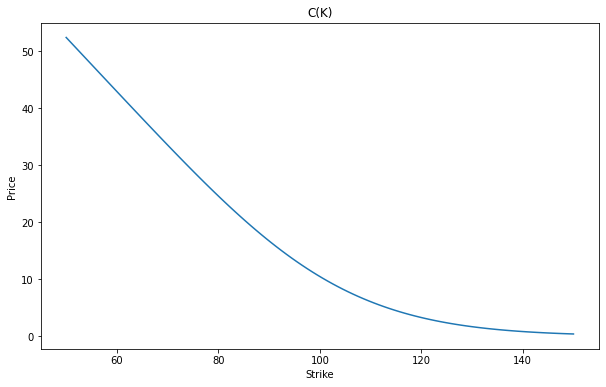

In [9]:
# Parameters
S = 100       # Current stock price
r = 0.05      # Risk-free rate
T = 1         # Time to maturity (1 year)
sigma = 0.2   # Volatility

# Generate strikes
strikes = np.linspace(50, 150, 100)

# Define Black-Scholes Call Price
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    return call_price

# Compute call prices for each strike
call_prices = np.array([black_scholes_call(S, K, T, r, sigma) for K in strikes])

#Plotting C(K)
plt.figure(figsize=(10,6))
plt.plot(strikes, call_prices)
plt.title('C(K)')
plt.ylabel('Price')
plt.xlabel('Strike')
plt.show()

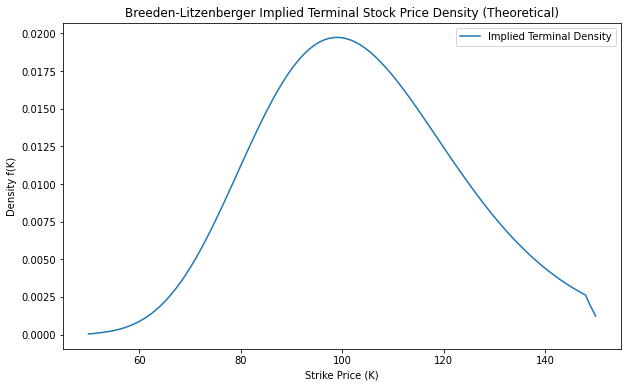

In [10]:
# Using NumPy's gradient function for numerical differentiation
dK = strikes[1] - strikes[0]
first_deriv = np.gradient(call_prices, dK)
second_deriv = np.gradient(first_deriv, dK)

# Apply discount factor to obtain density
risk_neutral_density = np.exp(r*T) * second_deriv

plt.figure(figsize=(10, 6))
plt.plot(strikes, risk_neutral_density, label='Implied Terminal Density')
plt.xlabel('Strike Price (K)')
plt.ylabel('Density f(K)')
plt.title('Breeden-Litzenberger Implied Terminal Stock Price Density (Theoretical)')
plt.legend()
plt.show()

<a id='3' > </a>
# <u>3.BL Formula vizualization with actual data

<a id='3.1' > </a>
## <u>3.1 Fecthing data from yfinance

Available expiration dates: ('2025-02-14', '2025-02-21', '2025-02-28', '2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28', '2025-04-17', '2025-05-16', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-06-17')


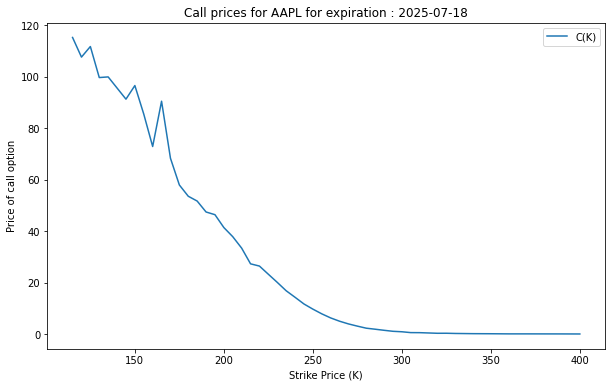

In [29]:
# Example: Fetching option chain for a given stock (e.g., AAPL) for a specific expiration
ticker = 'AAPL'
stock = yf.Ticker(ticker)

# Get expiration dates and choose one
expirations = stock.options
print("Available expiration dates:", expirations)

# Let's pick the first expiration date for illustration
chosen_exp = expirations[10]
opt_chain = stock.option_chain(chosen_exp)

# Use call options data
calls = opt_chain.calls
# Filter and sort by strike
calls = calls.sort_values('strike')

# Extract strikes and call prices
strikes_market = calls['strike'].values
call_prices_market = calls['lastPrice'].values

plt.figure(figsize=(10, 6))
plt.plot(strikes_market, call_prices_market, label='C(K)')
plt.xlabel('Strike Price (K)')
plt.ylabel('Price of call option')
plt.title(f'Call prices for {ticker} for expiration : {chosen_exp}')
plt.legend()
plt.show()

<a id='3.2' > </a>
## <u>3.2 Spline interpolation

In order to ensure that assumption (2) is fullfilled, meaning that the curve is smooth (a.k.a twice differentiable), we need to interpolate the curve. We will do that with a spline interpolation which specifically optimizes so that the curve is twice differentiable.

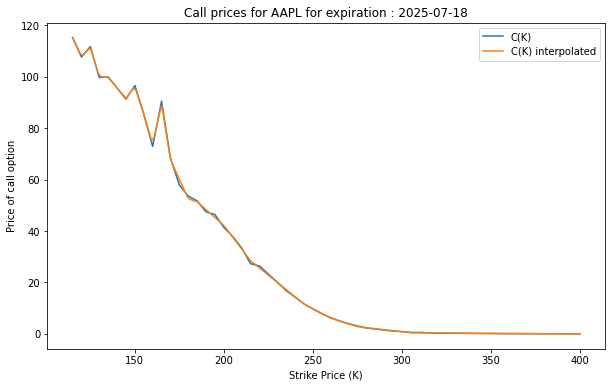

In [50]:
# Spline interpolation (choose smoothing factor as needed)
spline = UnivariateSpline(strikes_market, call_prices_market, s=15, k=1)
strikes_interp = np.linspace(strikes_market.min(), strikes_market.max(), 200)
call_prices_interp = spline(strikes_interp)

#Plotting the interpolation
plt.figure(figsize=(10, 6))
plt.plot(strikes_market, call_prices_market, label='C(K)')
plt.plot(strikes_interp, call_prices_interp, label='C(K) interpolated')
plt.xlabel('Strike Price (K)')
plt.ylabel('Price of call option')
plt.title(f'Call prices for {ticker} for expiration : {chosen_exp}')
plt.legend()
plt.show()

If the fit is satisfactory, we can go on and get the density of the terminal stock price on that maturity by differentiating twice.

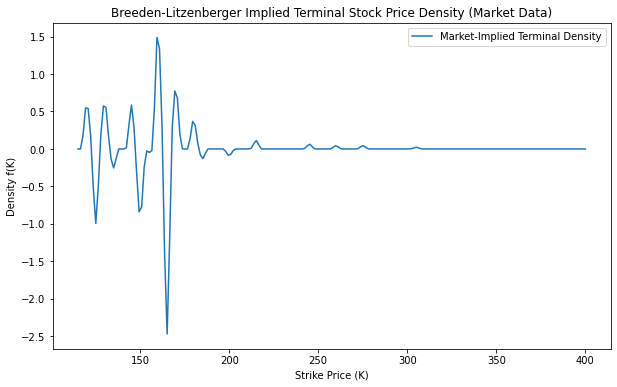

In [51]:
dK_market = strikes_interp[1] - strikes_interp[0]
first_deriv_market = np.gradient(call_prices_interp, dK_market)
second_deriv_market = np.gradient(first_deriv_market, dK_market)

# For real data, you will need to know the actual risk-free rate and time to maturity
r_market = 0.05  # Example value; replace with current rate
T_market = 0.001  # Example: 3 months to expiration
risk_neutral_density_market = np.exp(r_market*T_market) * second_deriv_market

plt.figure(figsize=(10, 6))
plt.plot(strikes_interp, risk_neutral_density_market, label='Market-Implied Terminal Density')
plt.xlabel('Strike Price (K)')
plt.ylabel('Density f(K)')
plt.title('Breeden-Litzenberger Implied Terminal Stock Price Density (Market Data)')
plt.legend()
plt.show()

As we can see, market data is too noisy for us to get a grasp of the curvature with a simple spline interpolation. We will useother interpolation methods to try and get a better fit.

<a id='3.3' > </a>
## <u>3.3 LOWESS interpolation

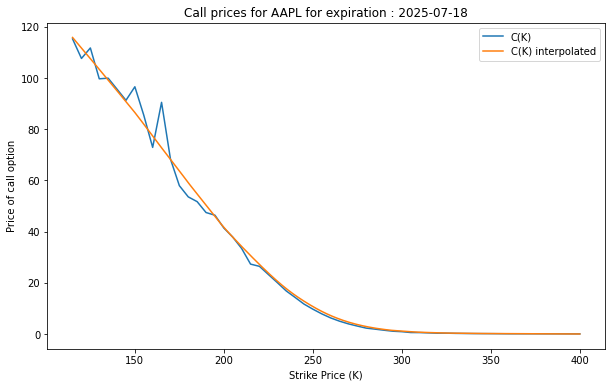

In [97]:
import statsmodels.api as sm

# frac defines the fraction of data used when estimating each value
lowess_result = sm.nonparametric.lowess(call_prices_market, strikes_market, frac=0.3)
# Extract the smoothed values
strikes_lowess = lowess_result[:, 0]
call_prices_lowess = lowess_result[:, 1]

# Interpolate on an even grid if needed
from scipy.interpolate import interp1d
interp_lowess = interp1d(strikes_lowess, call_prices_lowess, kind='cubic')
strikes_interp = np.linspace(strikes_lowess.min(), strikes_lowess.max(), 400)
call_prices_interp = interp_lowess(strikes_interp)

#Plotting the interpolation
plt.figure(figsize=(10, 6))
plt.plot(strikes_market, call_prices_market, label='C(K)')
plt.plot(strikes_interp, call_prices_interp, label='C(K) interpolated')
plt.xlabel('Strike Price (K)')
plt.ylabel('Price of call option')
plt.title(f'Call prices for {ticker} for expiration : {chosen_exp}')
plt.legend()
plt.show()

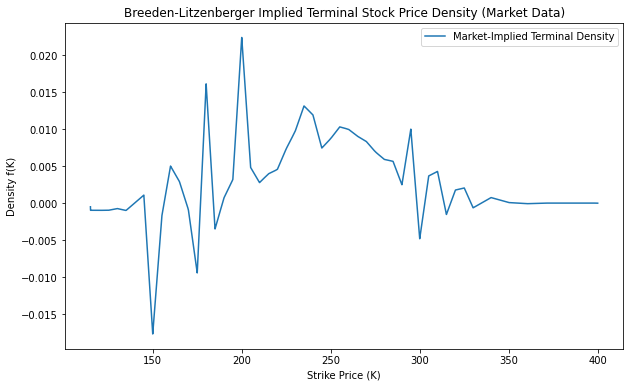

In [96]:
dK_market = strikes_interp[1] - strikes_interp[0]
first_deriv_market = np.gradient(call_prices_interp, dK_market)
second_deriv_market = np.gradient(first_deriv_market, dK_market)

# For real data, you will need to know the actual risk-free rate and time to maturity
r_market = 0.05  # Example value; replace with current rate
T_market = 0.001  # Example: 3 months to expiration
risk_neutral_density_market = np.exp(r_market*T_market) * second_deriv_market

plt.figure(figsize=(10, 6))
plt.plot(strikes_interp, risk_neutral_density_market, label='Market-Implied Terminal Density')
plt.xlabel('Strike Price (K)')
plt.ylabel('Density f(K)')
plt.title('Breeden-Litzenberger Implied Terminal Stock Price Density (Market Data)')
plt.legend()
plt.show()

We still get something too erratic.

<a id='3.4' > </a>
## <u>3.4 Adding a Savizky - Golay Filter to smooth the data 

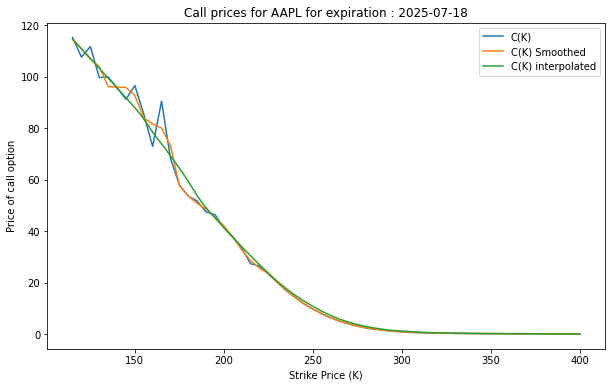

In [107]:
from scipy.signal import savgol_filter

# window_length must be odd, and polyorder is the order of the polynomial fit
call_prices_smoothed = savgol_filter(call_prices_market, window_length=5, polyorder=3)

# re interpolate data : 
lowess_result = sm.nonparametric.lowess(call_prices_smoothed, strikes_market, frac=0.3)
# Extract the smoothed values
strikes_lowess = lowess_result[:, 0]
call_prices_lowess = lowess_result[:, 1]

# Interpolate on an even grid if needed
from scipy.interpolate import interp1d
interp_lowess = interp1d(strikes_lowess, call_prices_lowess, kind='cubic')
strikes_interp = np.linspace(strikes_lowess.min(), strikes_lowess.max(), 400)
call_prices_interp = interp_lowess(strikes_interp)

#Plotting the interpolation
plt.figure(figsize=(10, 6))
plt.plot(strikes_market, call_prices_market, label='C(K)')
plt.plot(strikes_market, call_prices_smoothed, label='C(K) Smoothed')
plt.plot(strikes_interp, call_prices_interp, label='C(K) interpolated')
plt.xlabel('Strike Price (K)')
plt.ylabel('Price of call option')
plt.title(f'Call prices for {ticker} for expiration : {chosen_exp}')
plt.legend()
plt.show()

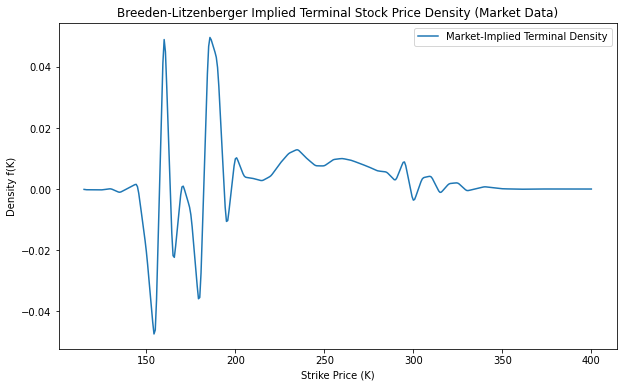

In [108]:
dK_market = strikes_interp[1] - strikes_interp[0]
first_deriv_market = np.gradient(call_prices_interp, dK_market)
second_deriv_market = np.gradient(first_deriv_market, dK_market)

# For real data, you will need to know the actual risk-free rate and time to maturity
r_market = 0.05  # Example value; replace with current rate
T_market = 0.001  # Example: 3 months to expiration
risk_neutral_density_market = np.exp(r_market*T_market) * second_deriv_market

plt.figure(figsize=(10, 6))
plt.plot(strikes_interp, risk_neutral_density_market, label='Market-Implied Terminal Density')
plt.xlabel('Strike Price (K)')
plt.ylabel('Density f(K)')
plt.title('Breeden-Litzenberger Implied Terminal Stock Price Density (Market Data)')
plt.legend()
plt.show()

<a id='3.5' > </a>
## <u>3.5 - Conclusion

To conclude, the Breeden-Litzenberger, while very beautiful in theory, is very hard to put in practice due to the noisyness of the data. We are trying to get the Implied distribution but the noisyness in the data is amplified when we differentiate, let alone twice.